<a href="https://colab.research.google.com/github/Orangefox76200/EMD-Capsule-LSTM/blob/main/CapsNet-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CapsNet-LSTM


## Install and import packages

Install pyEMD (EMD-signal 1.2.3)

In [1]:
!pip install EMD-signal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.0 MB/s 
     |████████████████████████████████| 76 kB 4.2 MB/s 
     |████████████████████████████████| 115 kB 46.7 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 


In [2]:
!pip install keras-utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2656 sha256=70d45ae32f0b87bf0549d7475cb4915b99e868771e38c409bed96821450e9ebc
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras-utils


In [3]:
#!pip list

Import Packages

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from PyEMD import EMD , Visualisation
from PyEMD import EEMD
from PyEMD import CEEMDAN
from matplotlib import pyplot as plt

## Select the time series from raw data

Stock Index Dataset: DJIA (Jan 04,2010-Dec 31,2019)

Upload **Orangefox76200/EMD-Capsule-LSTM/DJIA.xlsx** (Github) to Google Drive, then import it from Google Drive to EMD_Capsule_LSTM.ipynb

In [5]:
from google.colab import drive
drive.mount ('gdrive')
DJIA_raw = pd.read_excel ('gdrive/MyDrive/Colab Notebooks/DJIA.xlsx')
DJIA_raw

Mounted at gdrive


,Date,Open,High,Low,Close,Volume
0,"Jan 04, 2010",10430.69,10604.97,10430.69,10583.96,179780000
1,"Jan 05, 2010",10584.56,10584.56,10522.52,10572.02,188540000
2,"Jan 06, 2010",10564.72,10594.99,10546.55,10573.68,186040000
3,"Jan 07, 2010",10571.11,10612.37,10505.21,10606.86,217390000
4,"Jan 08, 2010",10606.40,10619.40,10554.33,10618.19,172710000
...,...,...,...,...,...,...
2511,"Dec 24, 2019",28572.57,28576.80,28503.21,28515.45,86150000
2512,"Dec 26, 2019",28539.46,28624.10,28535.15,28621.39,155970000
2513,"Dec 27, 2019",28675.34,28701.66,28608.98,28645.26,182280000
2514,"Dec 30, 2019",28654.76,28664.69,28428.98,28462.14,181600000


In [6]:
DJIA_raw.shape

(2516, 6)

In [7]:
DJIA_raw.ndim

2

In [8]:
DJIA_raw.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

In [9]:
DJIA_raw.describe()

,Open,High,Low,Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,17601.997731,17686.674499,17513.448593,17606.741574,1.895687e+08
std,5148.425951,5162.804510,5131.962418,5147.050108,1.106612e+08
min,9686.480000,9770.870000,9614.320000,9686.480000,8.410000e+06
25%,12977.190000,13044.985000,12921.337500,12981.207500,1.028275e+08
50%,17011.075000,17081.805000,16943.140000,17008.230000,1.516350e+08
75%,21426.617500,21488.690000,21383.437500,21411.107500,2.602025e+08
max,28675.340000,28701.660000,28608.980000,28645.260000,9.005100e+08


In [10]:
DJIA_raw.iloc[:,4]

0       10583.96
1       10572.02
2       10573.68
3       10606.86
4       10618.19
          ...   
2511    28515.45
2512    28621.39
2513    28645.26
2514    28462.14
2515    28538.44
Name: Close, Length: 2516, dtype: float64

Use the close price as the time series to be predicted.

In [11]:
DJIA_timeseries = DJIA_raw.iloc[:,4]
DJIA_timeseries.shape

(2516,)

In [12]:
DJIA_timeseries.ndim

1

In [13]:
DJIA_timeseries.iloc[:]

0       10583.96
1       10572.02
2       10573.68
3       10606.86
4       10618.19
          ...   
2511    28515.45
2512    28621.39
2513    28645.26
2514    28462.14
2515    28538.44
Name: Close, Length: 2516, dtype: float64

Convert Pandas series to Numpy Array

In [14]:
DJIA_timeseries_array = DJIA_timeseries.to_numpy()
DJIA_timeseries_array.shape


(2516,)

In [15]:
DJIA_timeseries_array.dtype

dtype('float64')

Convert object to float64

In [16]:
DJIA_timeseries_array = pd.to_numeric(DJIA_timeseries_array)

In [17]:
DJIA_timeseries_array.dtype

dtype('float64')

## Data splitting

Data splitting: the last 150 samples will be used as the test set. For the rest, the first 80% will be the training set, and the last 20% will be the validation set.

In [18]:
index_length = len(DJIA_timeseries_array)
DJIA_test = DJIA_timeseries_array[(index_length-150) : index_length] # the start index is included, but the end index is not included.

In [19]:
train_start_index = 0
train_end_index = round(0.8 * (index_length - 150))

In [20]:
DJIA_train = DJIA_timeseries_array[0 : train_end_index]

In [21]:
validation_start_index = train_end_index
validation_end_index = index_length-150


In [22]:
DJIA_validation = DJIA_timeseries_array[validation_start_index:validation_end_index]

## Normalization (min-max)

Calculate the maximum and the minimum of the training set sequence, then use them to normalize the training set, the validation set, and the test set.

In [23]:
# normalization of DJIA_train, DJIA_validation, and DJIA_test
DJIA_train_norm = (DJIA_train - min(DJIA_train))/(max(DJIA_train) - min(DJIA_train))
DJIA_validation_norm = (DJIA_validation - min(DJIA_train))/(max(DJIA_train) - min(DJIA_train))
DJIA_test_norm = (DJIA_test - min(DJIA_train))/(max(DJIA_train) - min(DJIA_train))

## Build the input sequences. Each sequence contains 250 elements. 

Combine train_norm, validation_norm, and test_norm.

In [24]:
# Could combine sequence together, then produce the datasets.
DJIA_norm = np.concatenate((DJIA_train_norm, DJIA_validation_norm, DJIA_test_norm), axis = 0)

For one time series, the input of the model is a sequence with 250 time steps. The output should be a prediction on the next time step. Based on this principle, generate input dataset and target dataset.

Input shape

3+D tensor with shape: batch_shape + (steps, input_dim)

Output shape

3+D tensor with shape: batch_shape + (new_steps, filters) steps value might have changed due to padding or strides.

Returns

A tensor of rank 3 representing activation(conv1d(inputs, kernel) + bias).

The input and output of the forecasting model should be array.

In [25]:
# the width of one sequence, could be tuned as one hyper-parameter
sequence_width = 250  
DJIA_norm_X = np.zeros((index_length-sequence_width, sequence_width),dtype=float)
DJIA_norm_Y = np.zeros((index_length-sequence_width, sequence_width),dtype=float)
for i in range(index_length-sequence_width):
  DJIA_norm_X[i] = DJIA_norm[i:i+sequence_width]
  DJIA_norm_Y[i] = DJIA_norm[i+1:i+sequence_width+1]

# split the norm_X, and norm_Y to get the corresponding training set, validation set, and test set.
# The last 150 samples is test set.
DJIA_norm_X_train = DJIA_norm_X[0 : train_end_index-sequence_width]
DJIA_norm_Y_train = DJIA_norm_Y[0 : train_end_index-sequence_width]
DJIA_norm_X_validation = DJIA_norm_X[train_end_index-sequence_width : validation_end_index-sequence_width]
DJIA_norm_Y_validation = DJIA_norm_Y[train_end_index-sequence_width : validation_end_index-sequence_width]
DJIA_norm_X_test = DJIA_norm_X[validation_end_index-sequence_width : index_length-sequence_width]
DJIA_norm_Y_test = DJIA_norm_Y[validation_end_index-sequence_width : index_length-sequence_width]

In [26]:
DJIA_norm_Y_train.shape

(1643, 250)

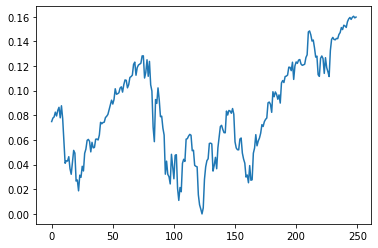

In [27]:
plt.plot(DJIA_norm_Y_train[1,:])

## Build the forecasing model

Define a function, namely CapsNet_LSTM, which creates the forecasting model.

In [28]:
# Input to base learner
inputs = keras.Input(shape=(sequence_width,1), name="sequence_input")

In [29]:
inputs.shape

TensorShape([None, 250, 1])

In [39]:
# LSTM layer 
x_1 = layers.LSTM(units = 32, return_sequences=True, activity_regularizer = tf.keras.regularizers.L2(l2=0.0001))(inputs)

In [40]:
x_1.shape

TensorShape([None, 250, 32])

In [41]:
output = layers.Dense(1)(x_1[:,249,:])

In [42]:
output.shape

TensorShape([None, 1])

In [43]:
# Build the model 'CNN_LSTM'
model = keras.Model(inputs=inputs, outputs=output, name="model_lstm")


In [44]:
model.summary()

Model: "model_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequence_input (InputLayer)  [(None, 250, 1)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 250, 32)           4352      
                                                                 
 tf.__operators__.getitem_1   (None, 32)               0         
 (SlicingOpLambda)                                               
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


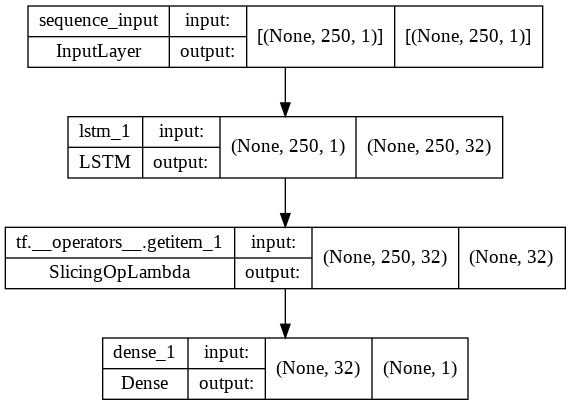

In [45]:
keras.utils.plot_model(model, "LSTM.png",show_shapes=True)

In [46]:
# setting optimizer 
Adam_1 = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
RMSprop_1 = tf.keras.optimizers.RMSprop(learning_rate=0.0001,rho=0.9,momentum=0.0,epsilon=1e-07,centered=False,name="RMSprop")

In [47]:
# compile model
model.compile(optimizer= Adam_1,  loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [48]:
# fit the model

training_history = model.fit(DJIA_norm_X_train, DJIA_norm_Y_train, validation_data=(DJIA_norm_X_validation, DJIA_norm_Y_validation), epochs=200, batch_size=50, verbose=1)

Epoch 1/200
33/33 [==============================] - 8s 31ms/step - loss: 0.1403 - root_mean_squared_error: 0.3701 - val_loss: 0.5932 - val_root_mean_squared_error: 0.7595
Epoch 2/200
33/33 [==============================] - 0s 14ms/step - loss: 0.0772 - root_mean_squared_error: 0.2714 - val_loss: 0.3404 - val_root_mean_squared_error: 0.5673
Epoch 3/200
33/33 [==============================] - 0s 14ms/step - loss: 0.0368 - root_mean_squared_error: 0.1803 - val_loss: 0.1715 - val_root_mean_squared_error: 0.3863
Epoch 4/200
33/33 [==============================] - 0s 14ms/step - loss: 0.0178 - root_mean_squared_error: 0.1127 - val_loss: 0.0942 - val_root_mean_squared_error: 0.2617
Epoch 5/200
33/33 [==============================] - 0s 14ms/step - loss: 0.0138 - root_mean_squared_error: 0.0898 - val_loss: 0.0733 - val_root_mean_squared_error: 0.2150
Epoch 6/200
33/33 [==============================] - 0s 14ms/step - loss: 0.0134 - root_mean_squared_error: 0.0872 - val_loss: 0.0696 - val_

In [49]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-242e07da-60de-8a35-369d-e2662daba2b4)


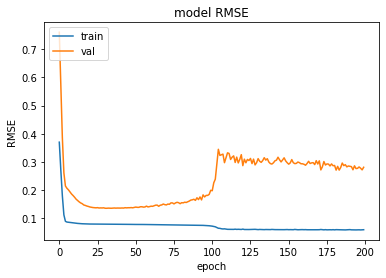

In [51]:
plt.plot(training_history.history['root_mean_squared_error'])
plt.plot(training_history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [52]:
# make a prediction on imf1
DJIA_norm_Y_hat = model.predict(DJIA_norm_X_test)

In [53]:
DJIA_norm_Y_hat_train = model.predict(DJIA_norm_X_train)

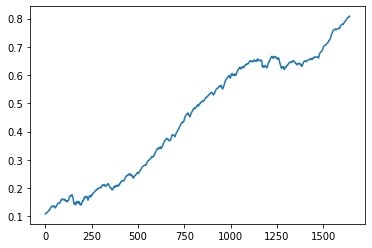

In [54]:
plt.plot(DJIA_norm_Y_hat_train)


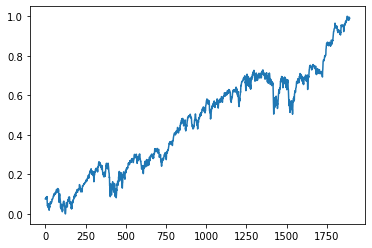

In [56]:
plt.plot(DJIA_train_norm)

In [57]:
DJIA_norm_Y_hat.shape

(150, 1)

In [58]:
DJIA_norm_Y_hat = np.reshape(DJIA_norm_Y_hat, (150,))

In [59]:
DJIA_norm_Y_hat.shape

(150,)

In [60]:
DJIA_test_norm.shape

(150,)

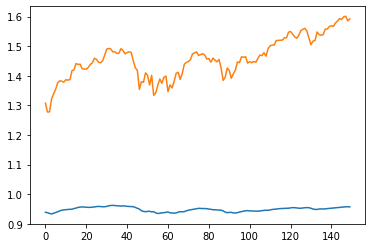

In [62]:
plt.plot(DJIA_norm_Y_hat)
plt.plot(DJIA_test_norm)
plt.show()

In [63]:
# reverse the norm prediction
DJIA_Y_hat = DJIA_norm_Y_hat * (max(DJIA_train) - min(DJIA_train)) + min(DJIA_train)


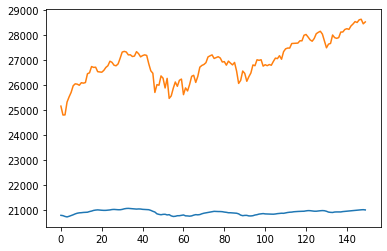

In [64]:
plt.plot(DJIA_Y_hat)
plt.plot(DJIA_test)
plt.show()

In [65]:
DJIA_Y_hat.shape

(150,)

In [66]:
DJIA_test.shape

(150,)

In [67]:
rmse = np.mean(np.sqrt(np.mean((DJIA_Y_hat - DJIA_test) ** 2)))

In [68]:
rmse

6080.36027126597